In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, FunctionTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC, LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/df_train.csv')
df_test = pd.read_csv('../data/df_test.csv')

df['ShapeFactor5'] = df['MajorAxisLength'] / df['Perimeter']
df_test['ShapeFactor5'] = df_test['MajorAxisLength'] / df_test['Perimeter']

df_all = pd.concat([df, df_test])

In [3]:
X = df.drop(columns=['Class'])
y = df['Class']

X_test = df_test.drop(columns=["Class"])
y_test = df_test["Class"]

In [8]:
pd.set_option('display.float_format', '{:.4f}'.format)

# Basic models evaluation

In [4]:
def evaluate_model_basic(models, X, y, X_test, y_test):
    results = []
    for model_name, model in models:
        if model_name == 'XGBoost':
            y = LabelEncoder().fit_transform(y)
            y_test = LabelEncoder().fit_transform(y_test)
        model.fit(X, y)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        results.append((model_name, accuracy, precision, recall))
    results = pd.DataFrame(results, columns=['Model Name', 'Accuracy', 'Precision', 'Recall'])
    results.sort_values('Accuracy', ascending=False, inplace=True)
    results.reset_index(drop=True, inplace=True)
    return results

In [10]:
models = [
    ('Dummy Classifier', DummyClassifier(strategy='most_frequent')),
    ('Decision Tree', DecisionTreeClassifier(random_state=311, max_depth=9, max_leaf_nodes=28, min_samples_leaf=2, criterion='log_loss')),
    ('SVC', SVC(kernel='linear', random_state=311)),
    ('Linear SVC', LinearSVC(random_state=311)),
    ('K Nearest Neighbors', KNeighborsClassifier(algorithm='auto', weights ='distance', n_neighbors=15, p=2)),
    ('Random Forest', RandomForestClassifier(random_state=311)),
    ('LGBM', LGBMClassifier(random_state=311)),
    ('XGBoost', XGBClassifier(random_state=311))
]

In [8]:
results = evaluate_model_basic(models, X, y, X_test, y_test)
print(results)

            Model Name  Accuracy  Precision  Recall
0                 LGBM    0.9286     0.9289  0.9286
1              XGBoost    0.9286     0.9289  0.9286
2        Random Forest    0.9220     0.9222  0.9220
3                  SVC    0.9108     0.9114  0.9108
4        Decision Tree    0.9080     0.9091  0.9080
5  K Nearest Neighbors    0.7118     0.7086  0.7118
6           Linear SVC    0.4781     0.4452  0.4781
7     Dummy Classifier    0.2606     0.0679  0.2606


# Feature selection

In [9]:
feature_names = [feature for feature in df.columns if feature != 'Class']

forest = RandomForestClassifier(random_state=311)
forest.fit(X, y)

RandomForestClassifier(random_state=311)

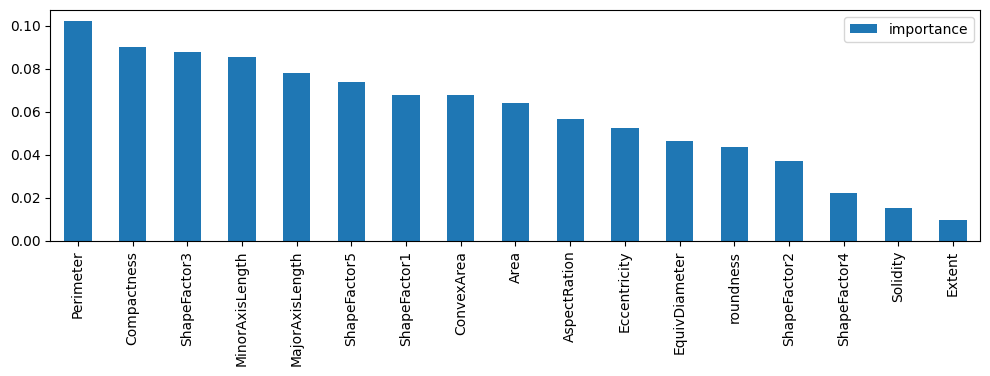

In [10]:
importances = forest.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(12, 3))
feature_importances_sorted = feature_importances.sort_values('importance', ascending=False)
feature_importances_sorted.plot.bar(ax=ax)
ax.set_xticklabels(feature_importances_sorted['feature'])
importance_threshold = feature_importances.max()['importance']

Wynika z tego, że możemy nie brać pod uwagę niektórych kolumn, ale musimy sprawdzić jeszcze, jak dużo z nich usunąć

In [8]:
def evaluate_feature_importance(X, y, importance_threshold):
    forest = RandomForestClassifier(random_state=311)
    forest.fit(X, y)

    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': forest.feature_importances_}).sort_values('importance', ascending=True)

    clf = RandomForestClassifier(random_state=0)
    clf.fit(X, y)

    results = []

    for i in range(len(feature_importances)):
        selected_features = feature_importances['feature'].iloc[i:]
        
        if feature_importances['importance'].iloc[i] > importance_threshold:
            break

        scores = cross_val_score(clf, X[selected_features], y, cv=5, scoring='accuracy')

        results.append({
            'num_features': len(selected_features),
            'accuracy': scores.mean(),
            'std': scores.std(),
            'dropped_feature': feature_importances['feature'].iloc[i]
        })

    return pd.DataFrame(results)

In [115]:
results_with_1 = evaluate_feature_importance(X, y, importance_threshold)
results_with_2 = evaluate_feature_importance(X, y, importance_threshold-0.0001)

(0.87, 0.93)

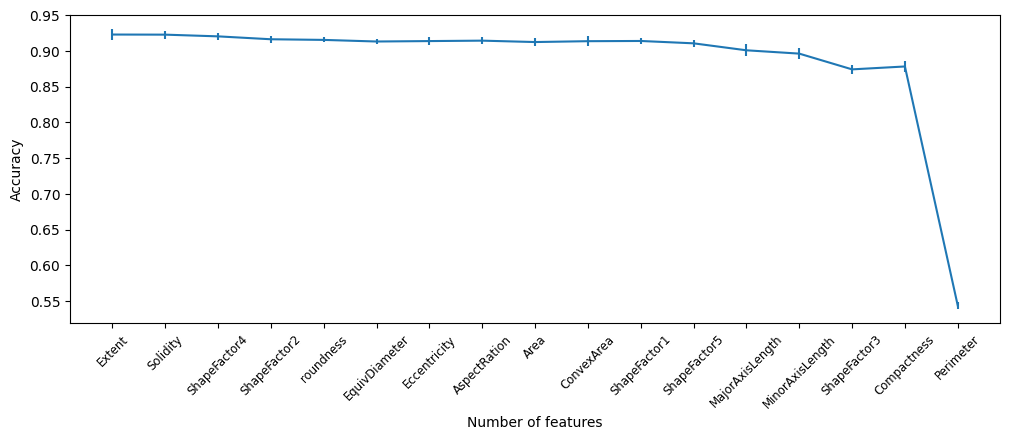

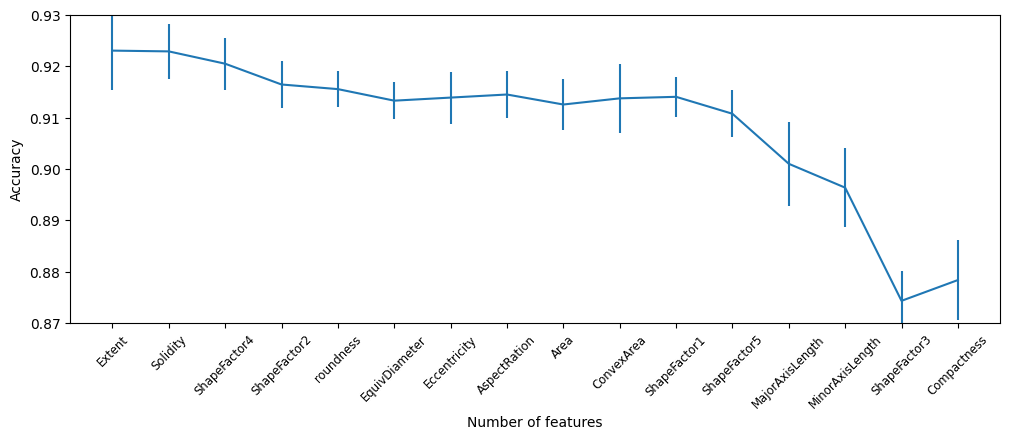

In [118]:
ax1 = results_with_1.plot(x='dropped_feature', y='accuracy', yerr='std', figsize=(12, 4), legend=False)
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(range(len(results_with_1['dropped_feature'])))
ax1.set_xticklabels(results_with_1['dropped_feature'], rotation=45, fontsize='small')

ax2 = results_with_2.plot(x='dropped_feature', y='accuracy', yerr='std', figsize=(12, 4), legend=False)
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.set_xticks(range(len(results_with_2['dropped_feature'])))
ax2.set_xticklabels(results_with_2['dropped_feature'], rotation=45, fontsize='small')

plt.ylim(0.87, 0.93)

Wykresy te pokazują, jak bardzo zmienia się accuracy gdy kolejno usuwamy kolumny z naszych danych w kolejności od najmniej znaczących (według Random Forest Clasiffier)

Wynika z nich, że na pewno powinnismy usunąć kolumnę:
- ShapeFactor3

ponieważ po jej usunięciu, na wykresie zauważamy znaczną poprawę wartości accuracy

Do tego możemy wziąć również pod uwagę kolumny których usuwanie podczas wykonania funkcji *evaluate_feature_importance* nieznacznie poprawia accuracy modelu albo zbytnio jej nie zmienia

### Różne kombinacje kolumn do wyrzucenia

In [13]:
features_to_drop1 = ['ShapeFactor3', 'EquivDiameter', 'Eccentricity', 'Area', 'ConvexArea']
features_to_drop2 = ['ShapeFactor3', 'EquivDiameter', 'Eccentricity', 'Area', 'ConvexArea', 'Extent', 'ShapeFactor2', 'roundness', 'AspectRation']

Okazuje się że możemy usunąć bardzo dużo kolumn bez znacznej utraty accuracy lub usunąć pojedyncze kolumny co daje większą wartość accuracy niż wyjściowe dane. W dalszej części projektu będziemy starali się ustalić które podejście będzie najbardziej efektywne

# Preprocessing danych

In [5]:
def drop_columns(X, columns_to_drop):
    return X.drop(columns=columns_to_drop, axis=1)

In [6]:
def standarize(df, column):
    return RobustScaler().fit_transform(np.array(df[column]).reshape(-1, 1))

In [7]:
def replace_outliers(data):
    for column in data.columns:
        if data[column].dtype in ['int64', 'float64']:  # tylko dla kolumn numerycznych
            Q1 = data.groupby('Class')[column].quantile(0.25)
            Q3 = data.groupby('Class')[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            mean = data.groupby('Class')[column].mean()
            for class_name in data['Class'].unique():
                data.loc[(data['Class'] == class_name) & (data[column] < lower_bound[class_name]), column] = mean[class_name]
                data.loc[(data['Class'] == class_name) & (data[column] > upper_bound[class_name]), column] = mean[class_name]
    return data

In [8]:
def test_models_with_preprocessing(df, models, columns_to_drop, to_standarize=False, replacing_outliers=False, cv=5):
    results = []
    if replacing_outliers:
        df = replace_outliers(df)

    X = df.drop(columns=['Class'])
    y = df['Class']
    for model_name, model in models:
        if model_name == 'XGBoost':
            y = LabelEncoder().fit_transform(y)

        for columns in columns_to_drop:
            X_transformed = drop_columns(X, columns)
            if to_standarize:
                for col in X_transformed.columns:
                    X_transformed[col] = standarize(X_transformed, col)
                
            scores = cross_validate(model, X_transformed, y, cv=cv,
                                    scoring=['accuracy', 'precision_weighted', 'recall_weighted'],
                                    return_train_score=False)
            accuracy = scores['test_accuracy'].mean()
            precision = scores['test_precision_weighted'].mean()
            recall = scores['test_recall_weighted'].mean()
            results.append((model_name, columns, accuracy, precision, recall))
    
    results = pd.DataFrame(results, columns=['Model Name', 'Columns Dropped', 'Accuracy', 'Precision', 'Recall'])
    results.sort_values('Accuracy', ascending=False, inplace=True)
    results.reset_index(drop=True, inplace=True)
    return results

### Utworzenie wstępnych modeli do testowania wyborów kolumn oraz ich skalowania

Wybieramy 5 najlepszych modeli ze wcześniejszego testowania

In [17]:
columns_to_drop = [
    features_to_drop1,
    features_to_drop2
]

models2 = [
    ('LGBM', LGBMClassifier(random_state=311)),
    ('XGBoost', XGBClassifier(random_state=311)),
    ('Random Forest', RandomForestClassifier(random_state=311)),
    ('SVC', SVC(kernel='linear', random_state=311)),
    ('Decision Tree', DecisionTreeClassifier(random_state=311, max_depth=9, max_leaf_nodes=28, min_samples_leaf=2, criterion='log_loss')),
]

In [52]:
results_dropped_columns_no_standarize_with_outliers = test_models_with_preprocessing(df_all, models2, columns_to_drop, to_standarize=False, replacing_outliers=False)

In [18]:
results_dropped_columns_standarize_with_outliers = test_models_with_preprocessing(df_all, models2, columns_to_drop, to_standarize=True, replacing_outliers=False)

In [19]:
results_dropped_columns_no_standarize_without_outliers = test_models_with_preprocessing(df_all, models2, columns_to_drop, to_standarize=False, replacing_outliers=True)

In [20]:
results_dropped_columns_standarize_without_outliers = test_models_with_preprocessing(df_all, models2, columns_to_drop, to_standarize=True, replacing_outliers=True)

In [22]:
print("Results for models with columns dropped, no standarization and with outliers\n")
print(results_dropped_columns_no_standarize_with_outliers)
print("\n-----------------------------------\n")
print("Results for models with columns dropped, standarization and with outliers\n")
print(results_dropped_columns_standarize_with_outliers)
print("\n-----------------------------------\n")
print("Results for models with columns dropped, no standarization and without outliers\n")
print(results_dropped_columns_no_standarize_without_outliers)
print("\n-----------------------------------\n")
print("Results for models with columns dropped, standarization and without outliers\n")
print(results_dropped_columns_standarize_without_outliers)

Results for models with columns dropped, no standarization and with outliers

      Model Name                                    Columns Dropped  Accuracy  \
0           LGBM  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9298   
1        XGBoost  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9277   
2  Random Forest  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9268   
3  Random Forest  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9256   
4           LGBM  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9237   
5        XGBoost  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9234   
6            SVC  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9153   
7            SVC  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9152   
8  Decision Tree  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9047   
9  Decision Tree  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9044   

   Precision  Recall  
0     0

In [24]:
res1 = results_dropped_columns_no_standarize_with_outliers
res2 = results_dropped_columns_standarize_with_outliers
res3 = results_dropped_columns_no_standarize_without_outliers
res4 = results_dropped_columns_standarize_without_outliers

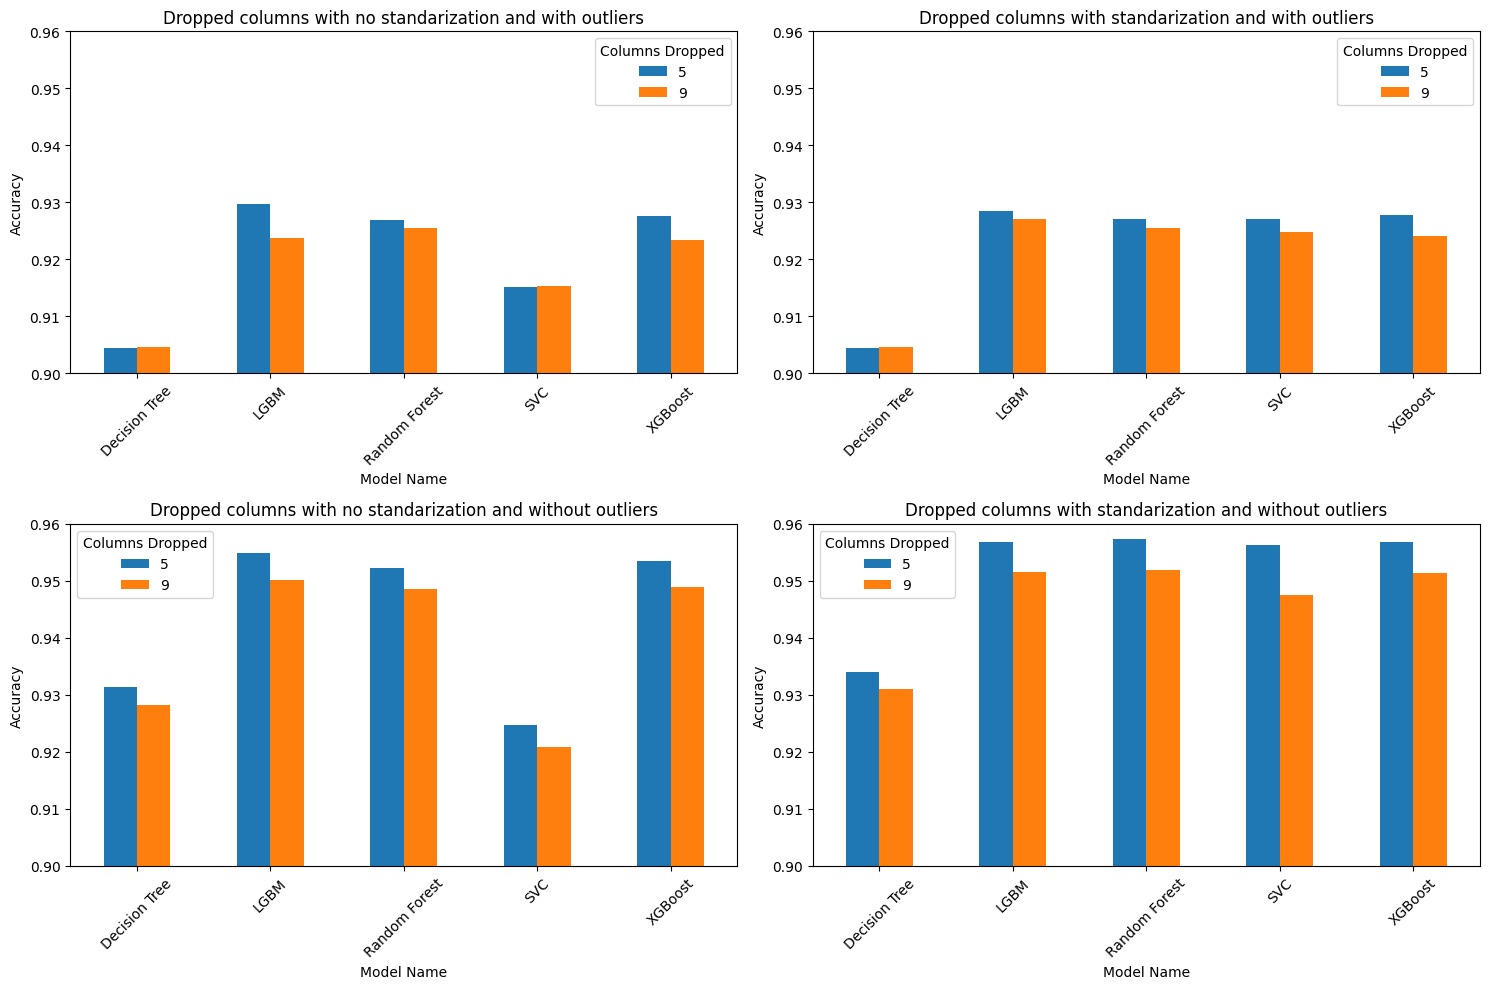

In [39]:
dataframes = [res1, res2, res3, res4]
titles = ['Dropped columns with no standarization and with outliers',
          'Dropped columns with standarization and with outliers',
          'Dropped columns with no standarization and without outliers',
          'Dropped columns with standarization and without outliers']

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, ax in enumerate(axs.flatten()):
    df = dataframes[i]
    # Przekształć listy na napisy
    df['Columns Dropped'] = df['Columns Dropped'].apply(lambda x: ', '.join(x))

    # Przekształć DataFrame
    df_pivot = df.pivot(index='Model Name', columns='Columns Dropped', values='Accuracy')

    # Stwórz wykres słupkowy
    df_pivot.plot(kind='bar', ax=ax)

    ax.set_title(titles[i])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Model Name')
    ax.set_xticklabels(df_pivot.index, rotation=45)
    ax.set_ylim(0.90, 0.96)
    ax.legend(["5", "9"], title='Columns Dropped')

plt.tight_layout()
plt.show()

Wnioski:
- sama standaryzacja parametrów zdecydowanie poprawia model SVC, w innych niewiele zmienia
- odrzucenie outlierów pozytywnie wpływa na wszystkie modele
- najlepsze wydają się modele LGBM, RandomForest, SVC i XGBoost dla których w dalszej części projektu przeprowadzimy tuning hiperparametrów 

# Tuning hiperparametrów

In [24]:
def get_best_params(X, y, model, param_grid, columns_to_drop):
    y = LabelEncoder().fit_transform(y)
    X_transformed = drop_columns(X, columns_to_drop)
    for col in X_transformed.columns:
        X_transformed[col] = standarize(X_transformed, col)
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid.fit(X_transformed, y)
    return grid.best_params_

In [40]:
param_grid_svc = {
    "C": [i for i in range(1, 50)],
    "kernel": ['rbf', 'linear'],
    "gamma": ['scale', 'auto']
}

param_grid_rf = {
    "n_estimators": [i for i in range(10, 150, 10)],
    "max_depth": [i for i in range(1, 8)],
    "min_samples_split": [i for i in range(2, 10)],
    "min_samples_leaf": [i for i in range(1, 10)],
    "criteria": ['gini', 'entropy', 'log_loss'],
    "bootstrap": [True, False]
}

param_grid_lgbm = {
    "boosting_type": ['gbdt', 'dart', 'goss', 'rf'],
    "max_depth": [i for i in range(1, 8)],
    "n_estimators": [i for i in range(10, 150, 10)],
}

param_grid_xgb = {
    "booster" : ['gbtree', 'gblinear'],
    "eta" : [0.05, 0.1, 0.2],
    "max_depth" : [2, 3, 4, 5],
    "min_child_weight" : [0.05, 0.1, 0.5, 1, 3]
}

In [28]:
best_params_svc = get_best_params(X, y, SVC(random_state = 311), param_grid_svc, features_to_drop2)
print(f"Best params for SVC: {best_params_svc}")

Best params for SVC: {'C': 9, 'gamma': 'auto', 'kernel': 'rbf'}


In [32]:
best_params_rf = get_best_params(X, y, RandomForestClassifier(), param_grid_rf, features_to_drop2)
print(f"Best params for Random Forest: {best_params_rf}")

Best params for Random Forest: {}


In [35]:
best_params_lgbm = get_best_params(X, y, LGBMClassifier(), param_grid_lgbm, features_to_drop2)
print(f"Best params for LGBM: {best_params_lgbm}")

Best params for LGBM: {'boosting_type': 'goss', 'max_depth': 3, 'n_estimators': 120}


In [41]:
best_params_xgb = get_best_params(X, y, XGBClassifier(), param_grid_xgb, features_to_drop2)
print(f"Best params for XGBoost: {best_params_xgb}")

Best params for XGBoost: {'booster': 'gbtree', 'eta': 0.2, 'max_depth': 3, 'min_child_weight': 0.05}


## Ocena modeli

In [10]:
# SVM_best = SVC(random_state=311, **best_params_svc)
# RF_best = RandomForestClassifier(random_state=311, **best_params_rf)
# LGBM_best = LGBMClassifier(random_state=311, **best_params_lgbm)
# XGB_best = XGBClassifier(random_state=311, **best_params_xgb)

SVM_best = SVC(random_state=311, C=9, gamma='auto', kernel='rbf')
RF_best = RandomForestClassifier(random_state=311)
LGBM_best = LGBMClassifier(random_state=311, boosting_type='goss', max_depth=3, n_estimators=120)
XGB_best = XGBClassifier(random_state=311, booster = 'gbtree', eta=0.2, max_depth=3, min_child_weight=0.05)

models_best = [
    ('SVM', SVM_best),
    ('Random Forest', RF_best),
    ('LGBM', LGBM_best),
    ('XGBoost', XGB_best)
]

In [11]:
def prepare_data(df):
    df = df.copy()
    df.drop(columns=features_to_drop2, inplace=True)
    for col in df.columns:
        if col != 'Class':
            df[col] = standarize(df, col)
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Class']), df['Class'], test_size=0.2, random_state=311)
    return X_train, y_train, X_test, y_test

In [14]:
X_train, y_train, X_test, y_test = prepare_data(df_all)

In [15]:
for model_name, model in models_best:
    if model_name == 'XGBoost':
        y_train = LabelEncoder().fit_transform(y_train)
        y_test = LabelEncoder().fit_transform(y_test)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
    print("\n----------------------------------------------------------\n")

Model: SVM
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.91      0.93       181
      BOMBAY       1.00      1.00      1.00        77
        CALI       0.95      0.95      0.95       249
    DERMASON       0.90      0.95      0.93       491
       HOROZ       0.96      0.95      0.95       268
       SEKER       0.96      0.97      0.96       295
        SIRA       0.89      0.83      0.86       345

    accuracy                           0.93      1906
   macro avg       0.94      0.94      0.94      1906
weighted avg       0.93      0.93      0.93      1906

Accuracy: 0.9302

----------------------------------------------------------

Model: Random Forest
              precision    recall  f1-score   support

    BARBUNYA       0.93      0.87      0.90       181
      BOMBAY       1.00      1.00      1.00        77
        CALI       0.94      0.94      0.94       249
    DERMASON       0.91      0.96      0.93       491
       HOROZ       0.9

### Najlepszym modelem wyda się być SVM

## Stacking

In [18]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacked_model = StackingClassifier(estimators=models_best, final_estimator=LogisticRegression())
stacked_model.fit(X_train, y_train)

y_pred = stacked_model.predict(X_test)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 7621, number of used features: 8
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -2.326622
[LightGBM] [Info] Start training from score -3.275702
[LightGBM] [Info] Start training from score -2.145197
[LightGBM] [Info] Start training from score -1.342271
[LightGBM] [Info] Start training from scor

In [19]:
print("Classification Report:")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Classification Report:
0.9317943336831059
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       181
           1       1.00      1.00      1.00        77
           2       0.96      0.95      0.95       249
           3       0.91      0.95      0.93       491
           4       0.95      0.96      0.96       268
           5       0.96      0.97      0.96       295
           6       0.89      0.83      0.86       345

    accuracy                           0.93      1906
   macro avg       0.94      0.94      0.94      1906
weighted avg       0.93      0.93      0.93      1906

